# =================================
# Airbnb price prediction modelling
# =================================

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib  

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

# =========================
# Step 1: Load Data
# =========================

In [2]:
bnb = pd.read_csv(r"C:\Users\cheru\Downloads\AB_NYC_2019.csv")
bnb.head

<bound method NDFrame.head of              id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

         

In [3]:
# Basic info
print("Data Shape:")
print(bnb.shape)
print("Data Info:")
print(bnb.info())
print("\nData Description:")
print(bnb.describe(include='all'))


Data Shape:
(48895, 16)
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 1

# =======================================
# Step 2: Exploratory Data Analysis (EDA)
# =======================================

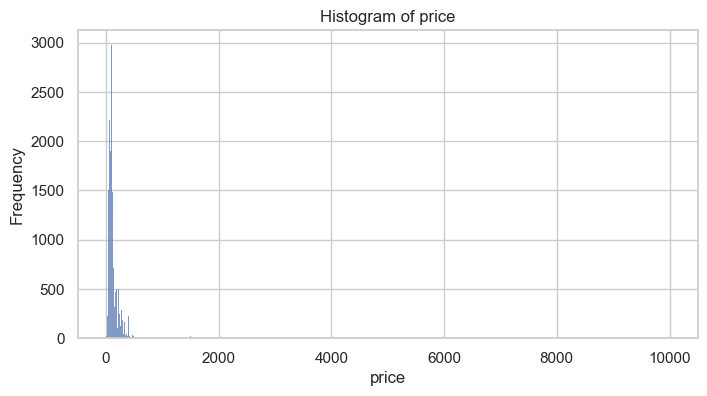

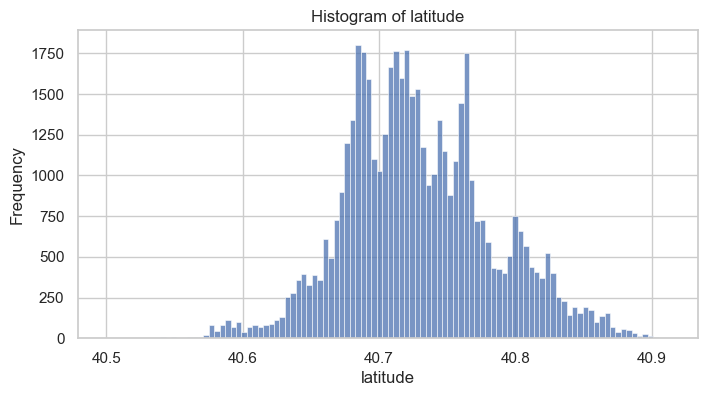

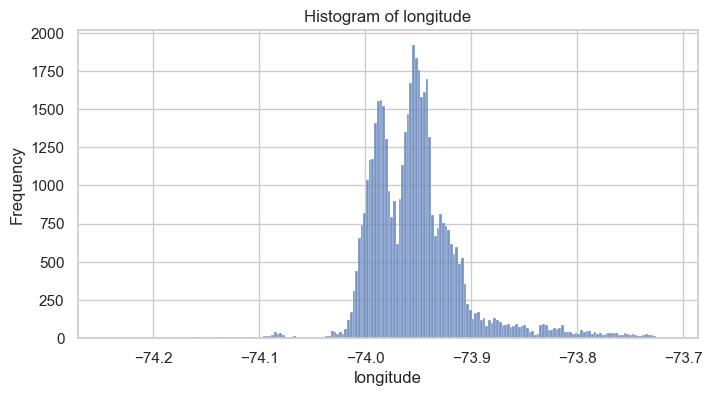

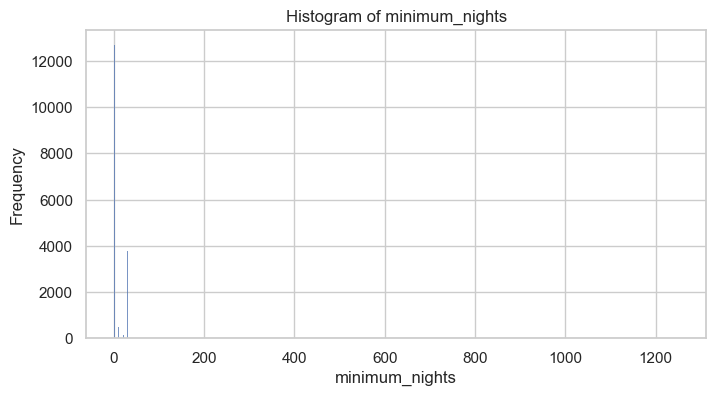

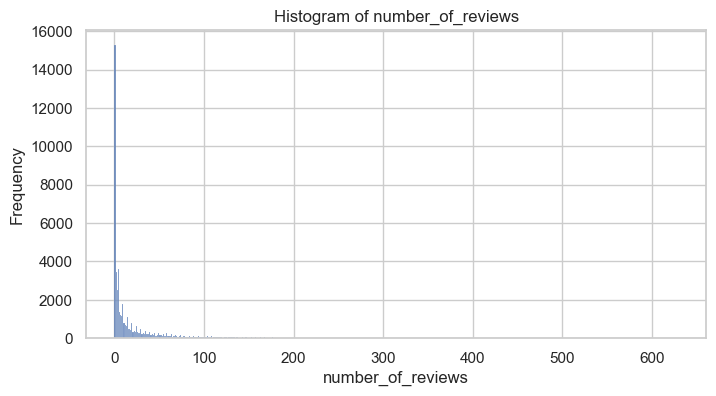

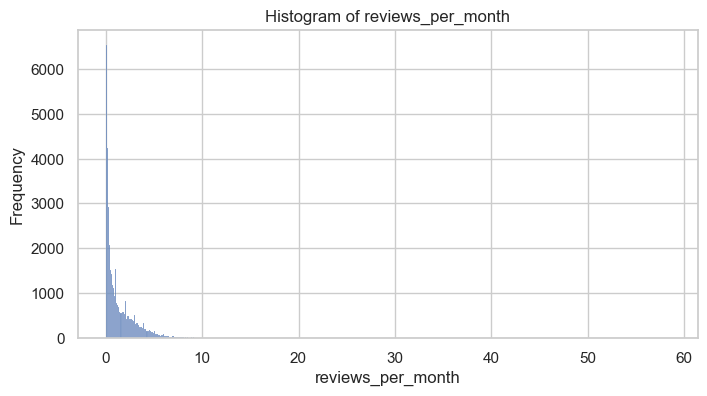

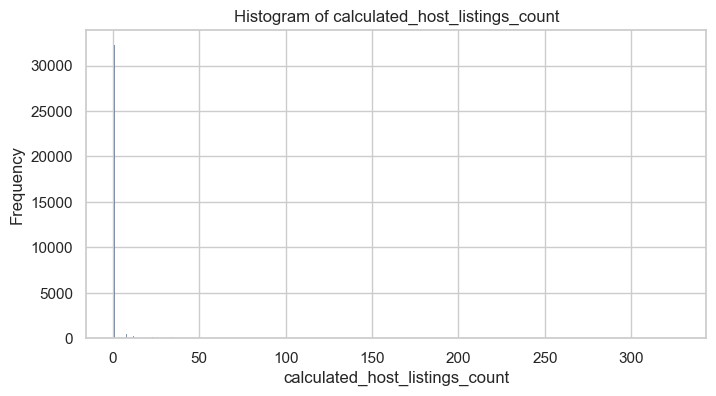

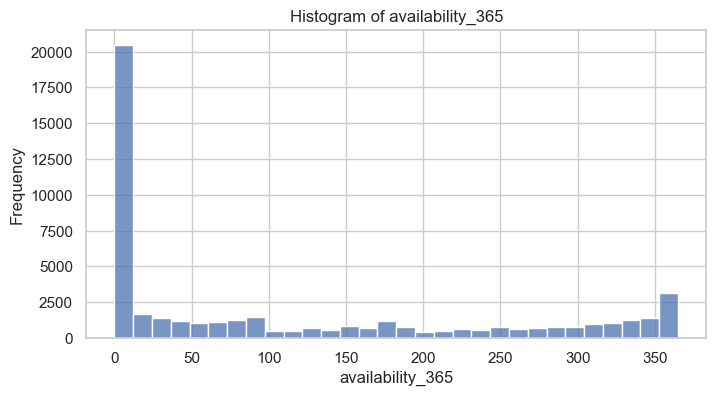

In [4]:
num_cols = [
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(bnb[col], kde=False)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

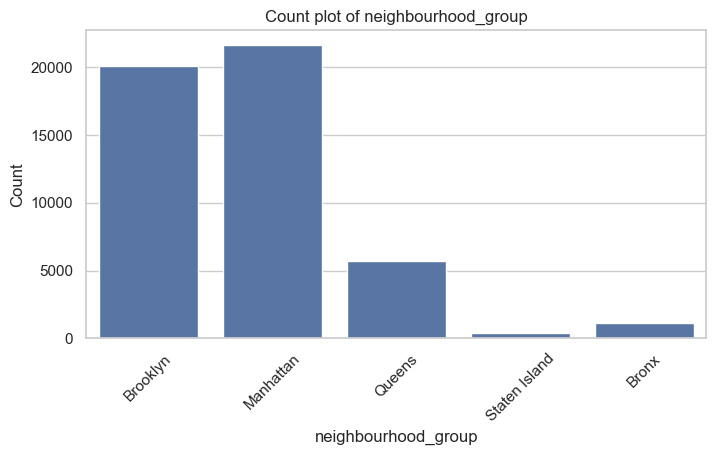

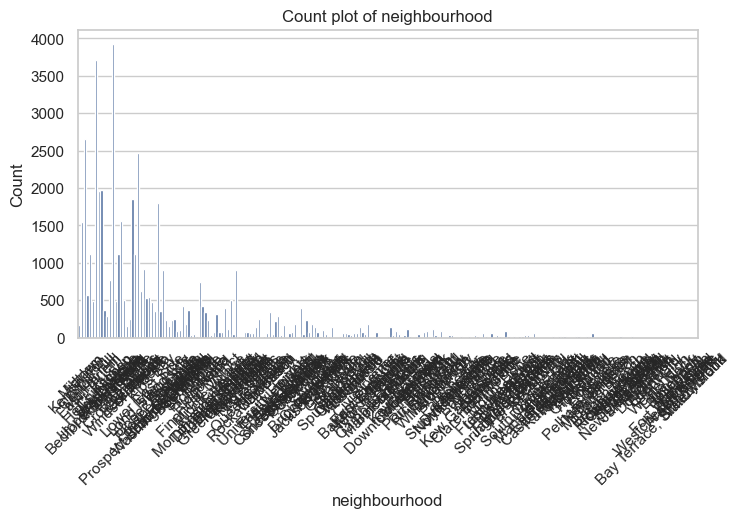

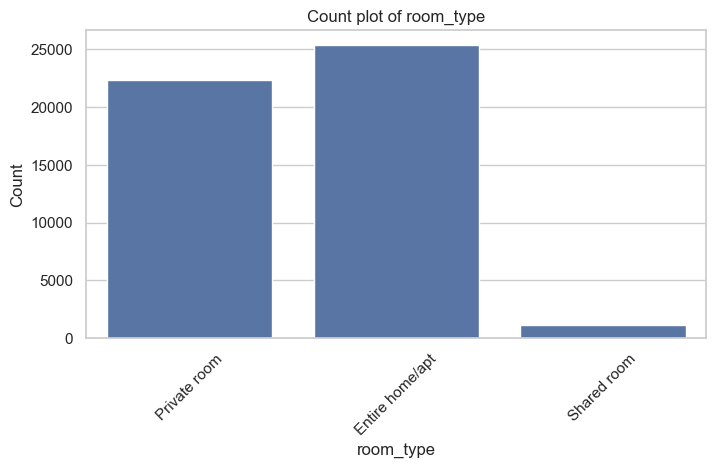

In [5]:
categorical_cols = [
    'neighbourhood_group','neighbourhood','room_type'
]

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=bnb[col])
    plt.title(f'Count plot of {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

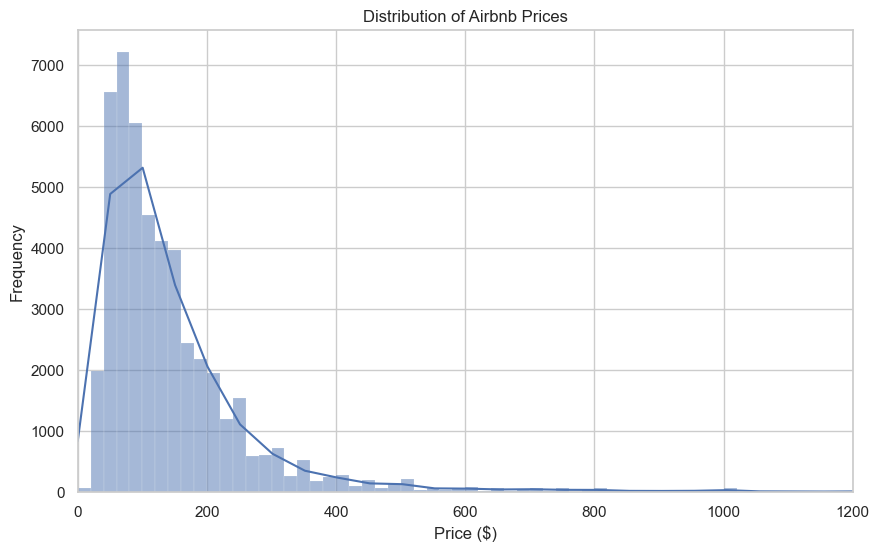

In [6]:
# Histogram of Prices
plt.figure(figsize=(10,6))
sns.histplot(bnb['price'], bins=500, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlim(0, 1200)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()



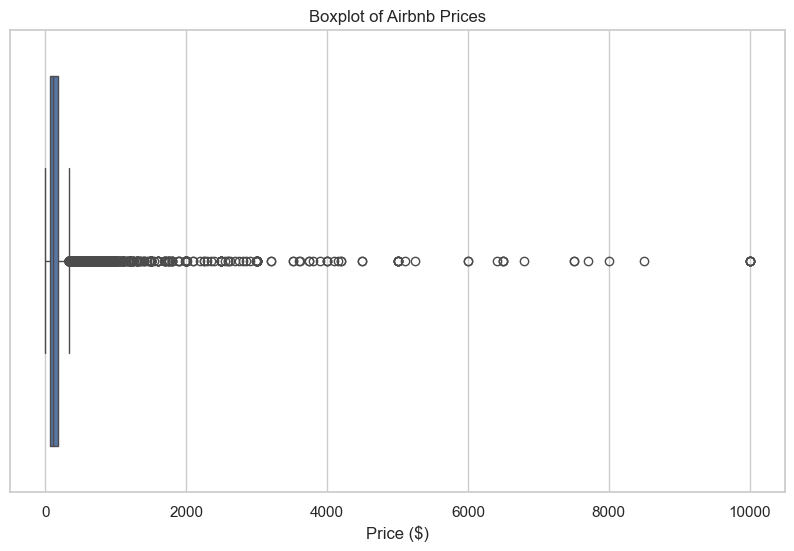

In [7]:
# Boxplot to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=bnb['price'])
plt.title('Boxplot of Airbnb Prices')
plt.xlabel('Price ($)')
plt.show()

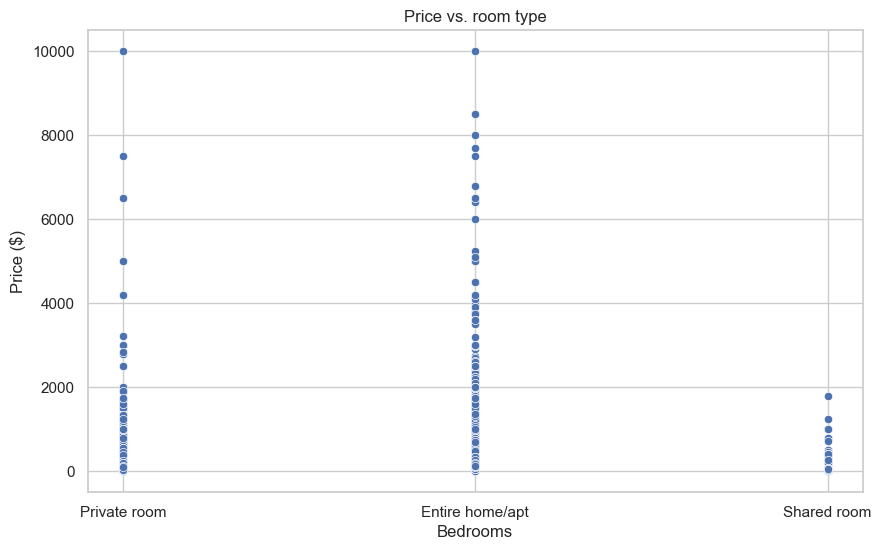

In [8]:
# Price vs. room type scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(x='room_type', y='price', data=bnb)
plt.title('Price vs. room type')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')
plt.show()

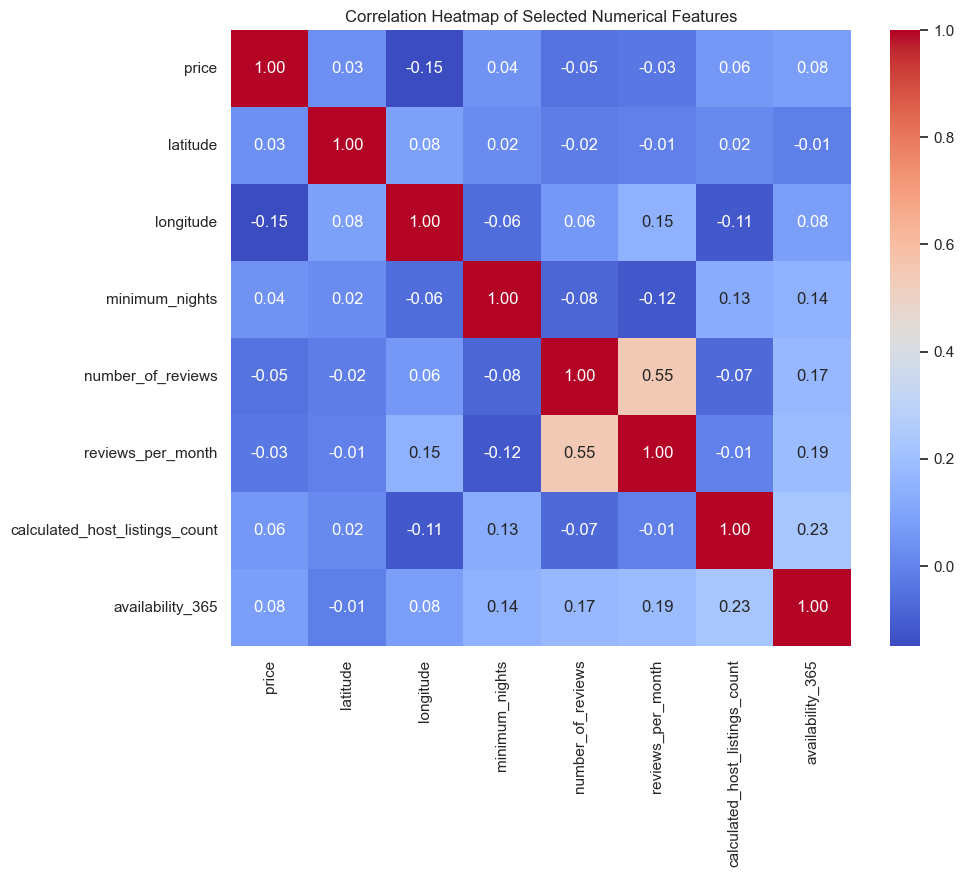

In [9]:
# Correlation heatmap
num_cols = [
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

corr = bnb[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Numerical Features')
plt.show()

# ==================
# Data Preprocessing
# ==================

In [10]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [11]:
columns_to_drop = ['id','host_id','name', 'host_name', 'last_review', 'reviews_per_month','latitude']
bnb.drop(columns=columns_to_drop, inplace=True)

In [12]:
bnb.shape

(48895, 9)

In [13]:
bnb.duplicated().sum()

4

In [14]:
# Define outlier removal function using IQR method
def remove_outliers_iqr(df, features):
    """
    Removes outliers from the specified features in the DataFrame using the IQR method.
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        initial_count = len(df)
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        final_count = len(df)
        print(f"Removed {initial_count - final_count} outliers from {feature}")
    return df

In [15]:
bnb = remove_outliers_iqr(bnb, ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365'])

Removed 2972 outliers from price
Removed 6185 outliers from minimum_nights
Removed 4536 outliers from number_of_reviews
Removed 3198 outliers from calculated_host_listings_count
Removed 3321 outliers from availability_365


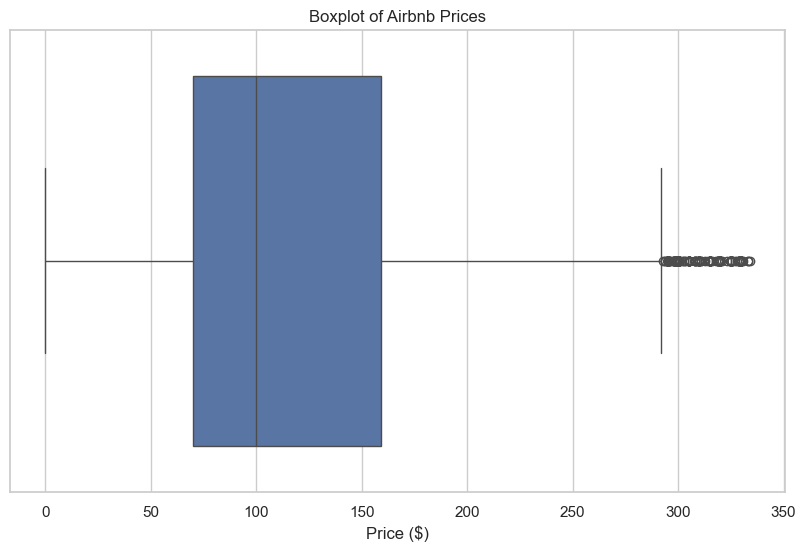

In [16]:
# Boxplot to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=bnb['price'])
plt.title('Boxplot of Airbnb Prices')
plt.xlabel('Price ($)')
plt.show()

In [17]:
bnb.shape

(28683, 9)

In [18]:
# Encode categorical features
categorical_cols = [
    'neighbourhood_group','neighbourhood','room_type'
]


In [19]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    bnb[col] = le.fit_transform(bnb[col])
    label_encoders[col] = le

In [20]:
bnb

,neighbourhood_group,neighbourhood,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
4,2,60,-73.94399,0,80,10,9,1,0
10,2,197,-73.96545,0,135,5,53,1,6
18,1,50,-73.94694,0,99,3,53,1,21
19,2,60,-73.94872,0,190,7,0,2,249
20,1,209,-73.95718,0,299,3,9,1,0
...,...,...,...,...,...,...,...,...,...
48889,3,103,-73.80844,1,65,1,0,2,163
48890,1,13,-73.94995,1,70,2,0,2,9
48891,1,28,-73.93317,1,40,4,0,2,36
48892,2,92,-73.94867,0,115,10,0,1,27


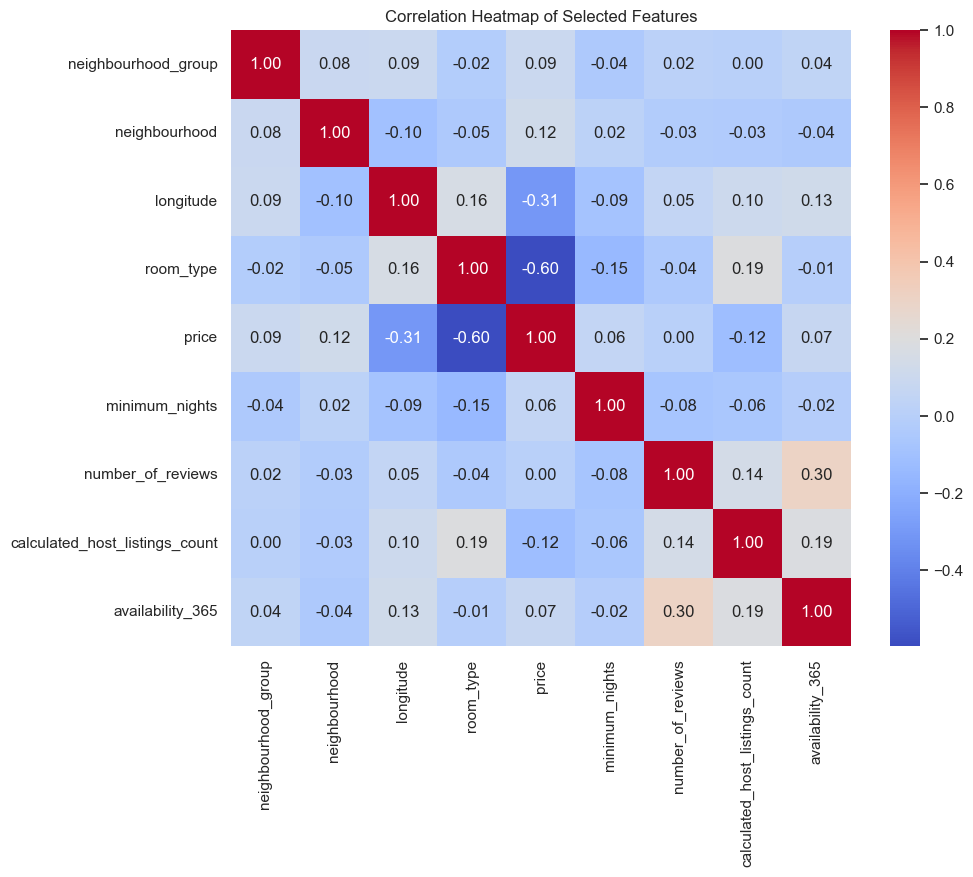

In [21]:
corr = bnb.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [22]:
# 5. Scale features
scaler = StandardScaler()
scaled_features = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']
bnb[scaled_features] = scaler.fit_transform(bnb[scaled_features])

In [23]:

# Define features and target
X = bnb.drop(['price'], axis=1, errors='ignore') 
y = bnb['price']

In [24]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
# List of models to evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Dictionary to store scores
results = {}

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    # Print results
    print(f"{name}:\n  MSE: {mse:.4f}\n  R2: {r2:.4f}\n")

Linear Regression:
  MSE: 0.5555
  R2: 0.4260

Ridge Regression:
  MSE: 0.5554
  R2: 0.4261

Lasso Regression:
  MSE: 0.9515
  R2: 0.0169

Decision Tree:
  MSE: 0.9402
  R2: 0.0286

Random Forest:
  MSE: 0.4969
  R2: 0.4866

Gradient Boosting:
  MSE: 0.4663
  R2: 0.5182

XGBoost:
  MSE: 0.4665
  R2: 0.5180



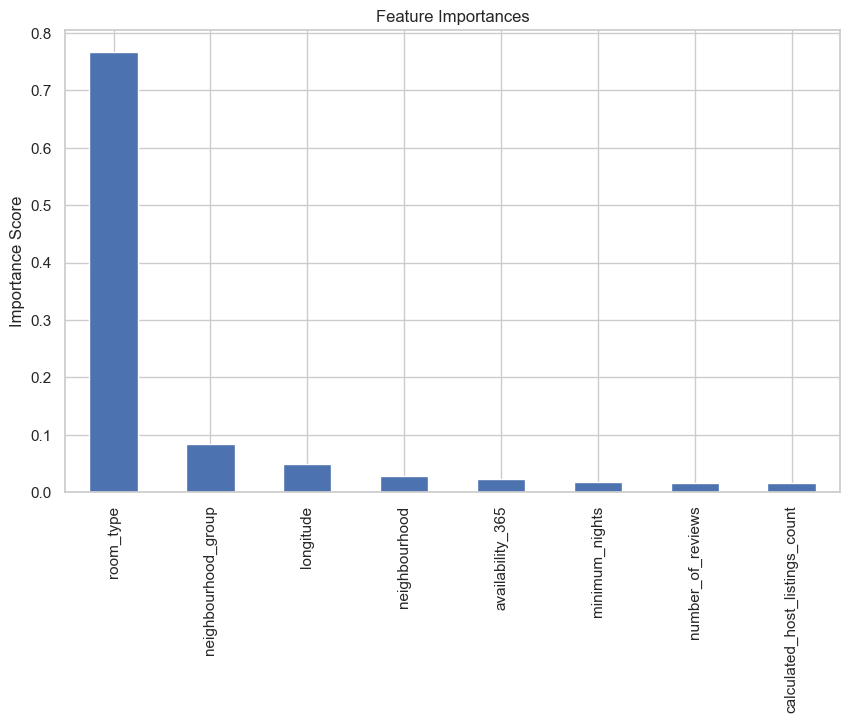

In [27]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_names = X_train.columns  # or list of feature names
feat_importances = pd.Series(importances, index=feature_names)

# Sort feature importances
feat_importances = feat_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance Score')
plt.show()

In [30]:
# Save the trained model
joblib.dump(best_model, 'Gradient Boosting.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the label encoder
joblib.dump(label_encoders, 'label_encoder.pkl')

NameError: name 'best_model' is not defined